In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.8 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
# noise = 'salt&pepper'
noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:00<00:00, 22347.18it/s]



salt&pepper noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 25248.64it/s]


salt&pepper noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

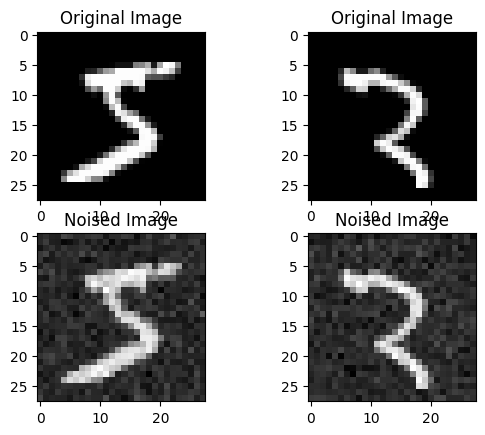

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

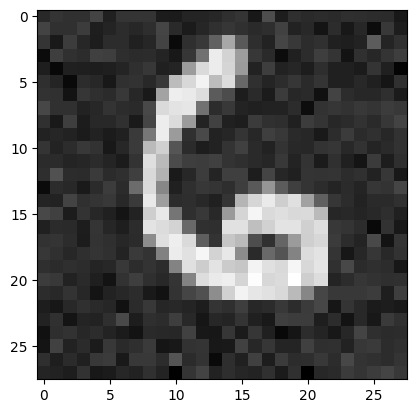

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

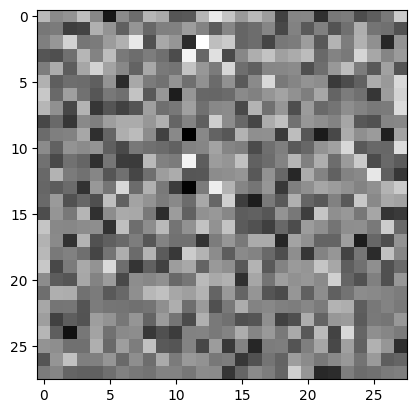

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(957.4922, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2291.239501953125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000, -0.0156, -0.0156,  ...,  0.0156,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0156,  0.0000, -0.0156],
        [-0.0156,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.0156,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0156,  ...,  0.0000,  0.0156,  0.0000],
        [ 0.0000,  0.0000, -0.0156,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


  0 3057.7104 1393.7560


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


  1 1911.9520 1195.9663


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


  2 1710.3173 1156.9677


100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


  3 1642.8839 1143.6323


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  4 1610.1703 1132.0797


100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


  5 1589.0848 1125.4896


100%|██████████| 313/313 [02:38<00:00,  1.97it/s]


  6 1572.3823 1115.8674


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


  7 1558.3483 1111.2550


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


  8 1545.5990 1103.9746


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


  9 1531.4736 1098.7251


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 10 1521.3326 1092.8854


100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


 11 1509.2487 1089.5024


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 12 1497.9020 1087.5348


100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


 13 1484.7201 1082.2667


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 14 1473.4397 1079.3839


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 15 1461.5995 1077.4335


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 16 1450.7277 1073.6141


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 17 1440.7551 1068.9467


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 18 1429.2723 1066.0695


100%|██████████| 313/313 [02:53<00:00,  1.80it/s]


 19 1419.5222 1066.4822


100%|██████████| 313/313 [02:55<00:00,  1.78it/s]


 20 1411.5150 1060.9504


100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


 21 1403.5543 1059.6510


100%|██████████| 313/313 [02:54<00:00,  1.79it/s]


 22 1394.5616 1056.9420


100%|██████████| 313/313 [02:54<00:00,  1.79it/s]


 23 1387.9513 1053.9336


100%|██████████| 313/313 [02:53<00:00,  1.81it/s]


 24 1381.8669 1054.4225


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 25 1375.2164 1051.7546


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 26 1369.4446 1050.3514


100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


 27 1363.9214 1049.7524


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 28 1358.4612 1046.8936


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 29 1353.6072 1043.8019


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 30 1349.6530 1046.3501


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 31 1344.4377 1044.4531


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 32 1340.8440 1040.9043


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 33 1336.5107 1039.5596


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


 34 1333.2789 1037.3740


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 35 1329.7457 1036.7008


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 36 1326.0804 1033.1857


100%|██████████| 313/313 [02:46<00:00,  1.88it/s]


 37 1321.5579 1034.4340


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


 38 1320.0552 1031.7433


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 39 1316.2432 1030.7749


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 40 1313.9561 1030.1256


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 41 1310.0315 1029.9054


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 42 1306.5809 1030.1458


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 43 1305.0133 1027.3911


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 44 1302.1904 1026.6078


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 45 1300.0624 1026.7966


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 46 1297.0459 1024.9010


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 47 1296.5624 1024.4839


100%|██████████| 313/313 [02:52<00:00,  1.82it/s]


 48 1293.2422 1023.2612


100%|██████████| 313/313 [02:53<00:00,  1.80it/s]


 49 1291.8890 1022.2941

  2 MSE    Topo  


100%|██████████| 313/313 [02:56<00:00,  1.78it/s]


  0 3080.7983 1409.6554


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


  1 1925.2943 1195.2003


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


  2 1712.5048 1152.6748


100%|██████████| 313/313 [02:54<00:00,  1.79it/s]


  3 1640.4487 1136.8677


100%|██████████| 313/313 [02:53<00:00,  1.81it/s]


  4 1608.3585 1123.8959


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


  5 1582.8970 1114.2522


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


  6 1565.8912 1106.9329


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


  7 1549.8616 1098.2909


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


  8 1535.4467 1093.0751


100%|██████████| 313/313 [02:47<00:00,  1.86it/s]


  9 1522.5540 1087.9773


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 10 1509.6414 1083.9663


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 11 1498.3790 1083.4362


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 12 1486.3256 1077.3062


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 13 1476.0682 1073.9896


100%|██████████| 313/313 [02:47<00:00,  1.86it/s]


 14 1466.5881 1073.1741


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 15 1455.7400 1069.0526


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 16 1448.4877 1066.1008


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 17 1436.6992 1064.1027


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 18 1428.1793 1060.5873


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 19 1419.9366 1059.4825


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 20 1411.5090 1057.3363


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 21 1403.6976 1053.8400


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 22 1397.1805 1052.6909


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 23 1389.0079 1052.1067


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 24 1383.8491 1048.4465


100%|██████████| 313/313 [02:53<00:00,  1.81it/s]


 25 1376.2350 1047.3112


100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


 26 1372.0289 1047.2008


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 27 1365.3092 1042.4081


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 28 1360.2302 1041.2078


100%|██████████| 313/313 [02:55<00:00,  1.79it/s]


 29 1356.2921 1040.5651


100%|██████████| 313/313 [02:53<00:00,  1.80it/s]


 30 1350.5594 1040.9387


100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


 31 1346.0662 1036.4419


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 32 1340.9850 1035.9871


100%|██████████| 313/313 [02:52<00:00,  1.82it/s]


 33 1338.1467 1035.3138


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 34 1333.7996 1034.2212


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 35 1330.6012 1034.0106


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 36 1327.3331 1032.3280


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 37 1323.4136 1032.0004


100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


 38 1319.6887 1029.0258


100%|██████████| 313/313 [02:54<00:00,  1.80it/s]


 39 1317.6858 1028.0995


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 40 1313.6379 1027.2207


100%|██████████| 313/313 [02:55<00:00,  1.78it/s]


 41 1310.0138 1025.7935


100%|██████████| 313/313 [02:55<00:00,  1.78it/s]


 42 1308.0150 1025.3247


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 43 1304.2589 1022.9435


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 44 1302.1177 1021.7072


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 45 1299.8950 1021.0352


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 46 1298.0795 1019.5475


100%|██████████| 313/313 [02:52<00:00,  1.82it/s]


 47 1295.4253 1019.9510


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 48 1292.6699 1017.5470


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 49 1290.2157 1017.0506

  3 MSE    Topo  


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


  0 3073.7166 1410.5416


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


  1 1907.9602 1192.2180


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


  2 1705.6162 1153.9698


100%|██████████| 313/313 [02:52<00:00,  1.82it/s]


  3 1634.5916 1136.2506


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


  4 1602.6859 1123.9290


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


  5 1574.8951 1114.3051


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


  6 1558.6893 1107.5742


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


  7 1540.7535 1102.0804


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


  8 1524.6383 1098.7141


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


  9 1510.7855 1093.1737


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 10 1499.8636 1088.5394


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 11 1486.7010 1083.7856


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 12 1475.7280 1082.3550


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]


 13 1464.6477 1078.4969


100%|██████████| 313/313 [02:44<00:00,  1.90it/s]


 14 1455.2327 1078.9115


100%|██████████| 313/313 [02:44<00:00,  1.91it/s]


 15 1442.7899 1072.1686


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 16 1434.9111 1069.9341


100%|██████████| 313/313 [02:41<00:00,  1.94it/s]


 17 1425.5786 1066.4323


100%|██████████| 313/313 [02:41<00:00,  1.93it/s]


 18 1417.4490 1066.2283


100%|██████████| 313/313 [02:42<00:00,  1.93it/s]


 19 1408.5006 1062.0529


100%|██████████| 313/313 [02:44<00:00,  1.91it/s]


 20 1401.7600 1059.6326


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


 21 1392.1980 1058.1665


100%|██████████| 313/313 [02:42<00:00,  1.92it/s]


 22 1386.1250 1055.1328


100%|██████████| 313/313 [02:43<00:00,  1.92it/s]


 23 1379.4943 1055.5090


100%|██████████| 313/313 [02:45<00:00,  1.89it/s]


 24 1372.2052 1052.5426


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 25 1366.2421 1051.6796


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 26 1359.9886 1047.7532


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 27 1354.9023 1046.1260


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 28 1347.6395 1044.7565


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 29 1343.2892 1042.8767


100%|██████████| 313/313 [02:48<00:00,  1.86it/s]


 30 1337.8611 1042.7393


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 31 1332.2443 1038.9004


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 32 1329.3513 1039.1494


100%|██████████| 313/313 [02:51<00:00,  1.82it/s]


 33 1325.5968 1036.4005


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 34 1320.1818 1035.0289


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 35 1317.5371 1032.4240


100%|██████████| 313/313 [02:51<00:00,  1.83it/s]


 36 1312.9309 1030.7207


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 37 1310.2627 1030.1648


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 38 1306.9384 1028.3822


100%|██████████| 313/313 [02:52<00:00,  1.81it/s]


 39 1304.0375 1028.3872


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 40 1301.1755 1028.6273


100%|██████████| 313/313 [02:48<00:00,  1.85it/s]


 41 1298.7623 1027.0830


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 42 1296.2177 1025.0883


100%|██████████| 313/313 [02:49<00:00,  1.84it/s]


 43 1295.2114 1025.0200


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 44 1290.3167 1023.4036


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


 45 1287.9340 1021.2078


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 46 1287.2158 1022.8936


100%|██████████| 313/313 [02:50<00:00,  1.83it/s]


 47 1284.8468 1019.7700


100%|██████████| 313/313 [02:49<00:00,  1.85it/s]


 48 1282.8467 1017.8173


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]

 49 1279.9871 1017.1802

CPU times: user 10h 42min, sys: 1min 18s, total: 10h 43min 18s
Wall time: 7h 4min 24s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

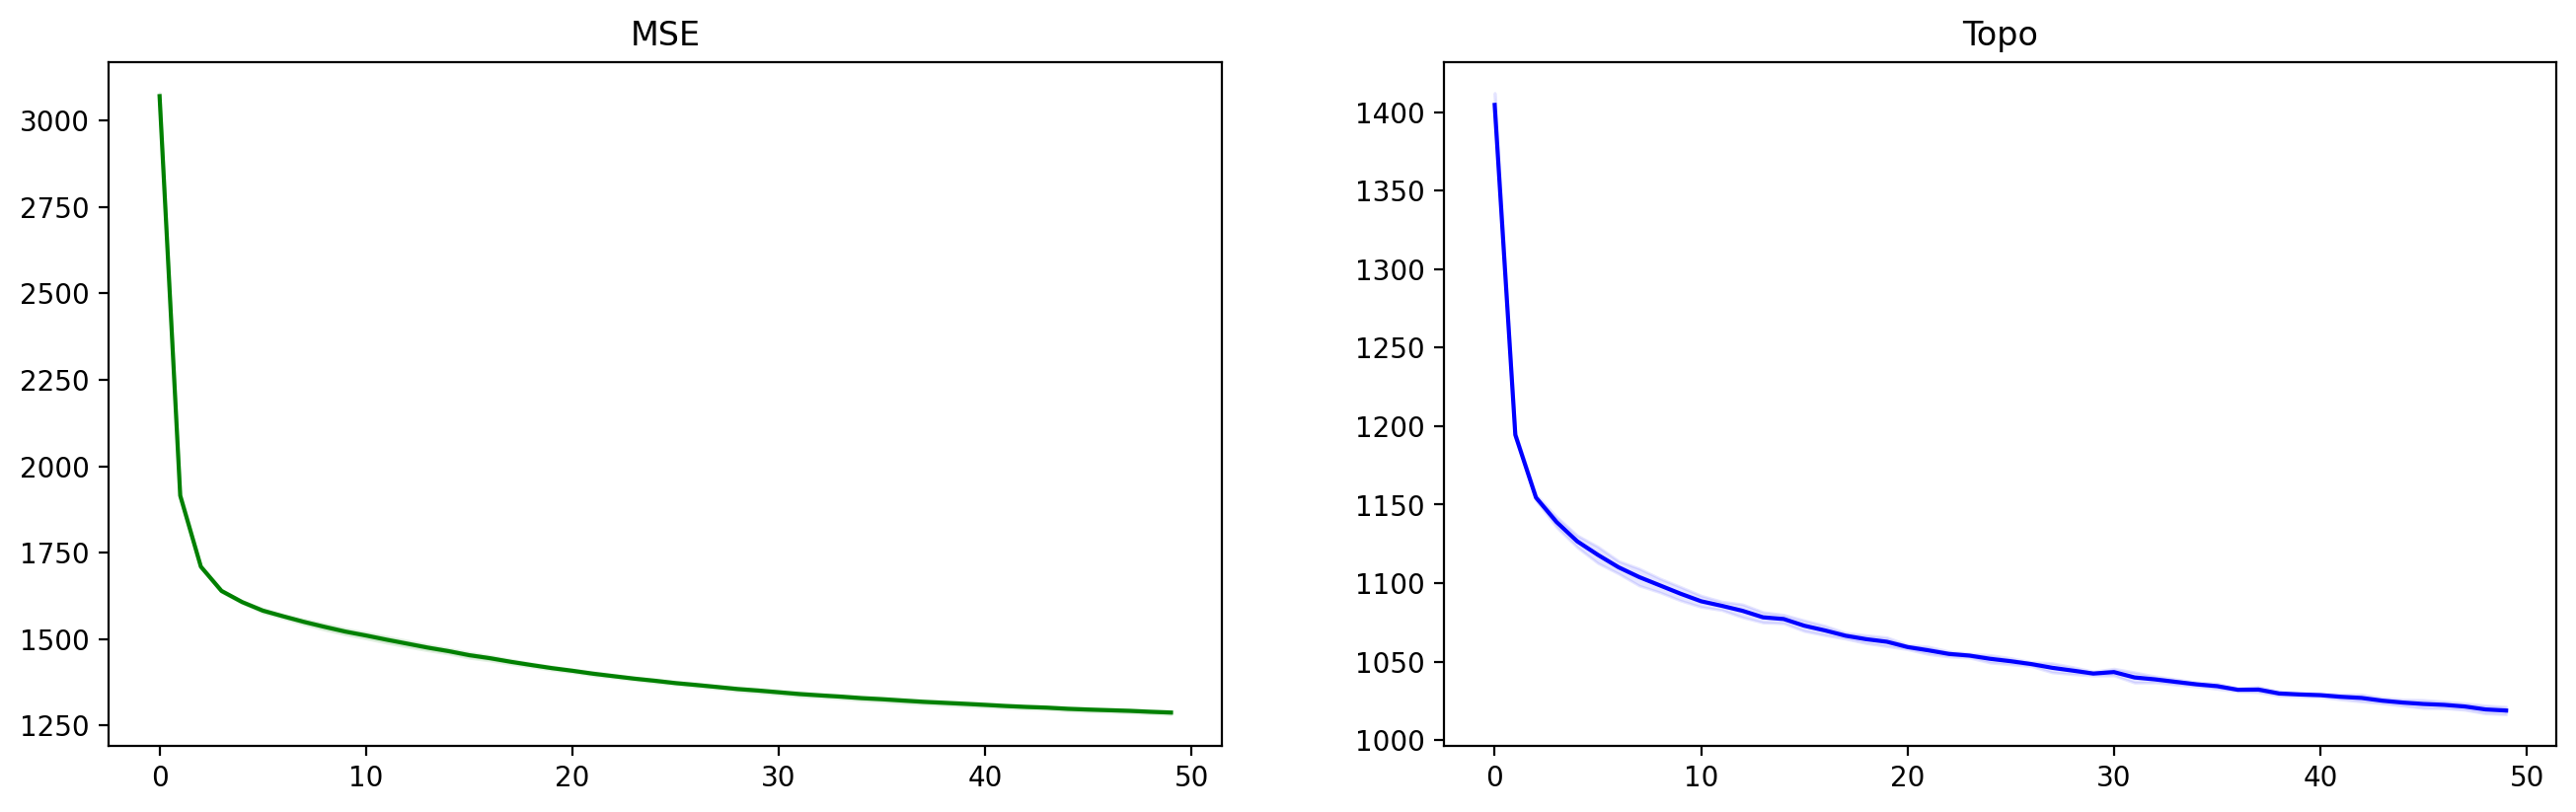

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

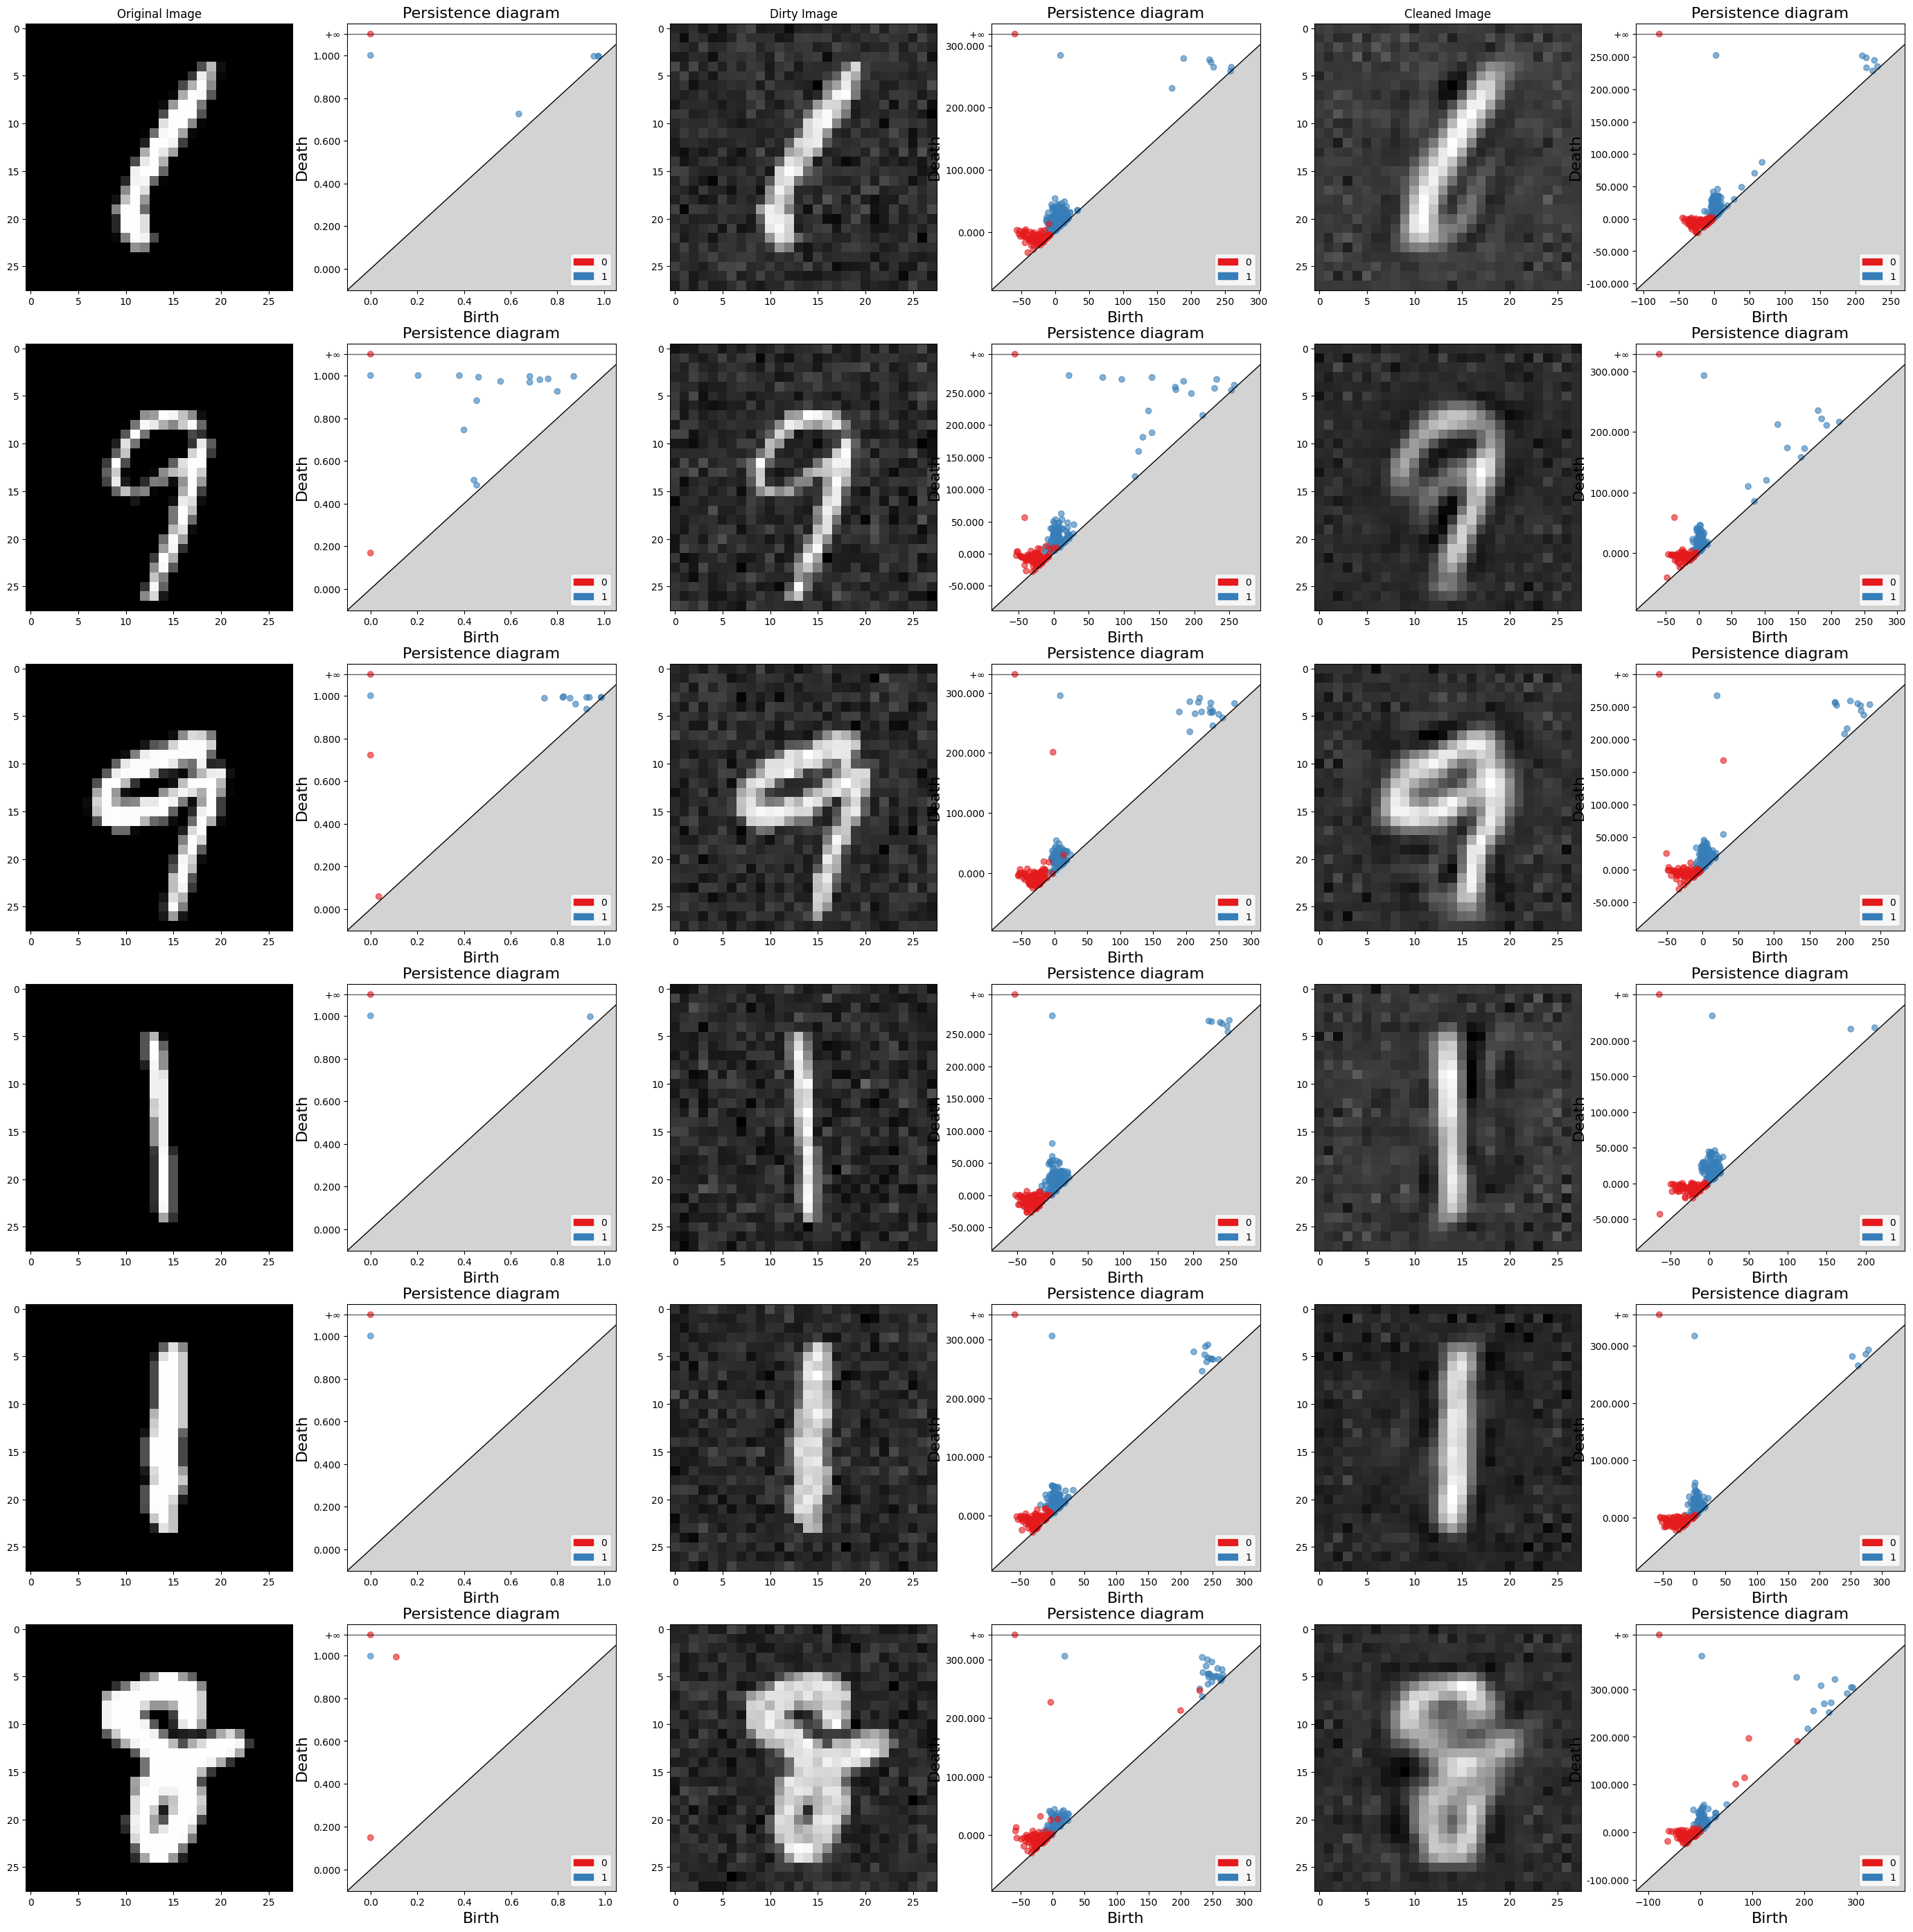

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[3057.71044922 1393.75598145]
  [1911.95202637 1195.96630859]
  [1710.31726074 1156.96765137]
  [1642.88391113 1143.63232422]
  [1610.17028809 1132.07971191]
  [1589.08483887 1125.48962402]
  [1572.38232422 1115.86743164]
  [1558.3482666  1111.25500488]
  [1545.59899902 1103.97460938]
  [1531.47363281 1098.72509766]
  [1521.3326416  1092.88537598]
  [1509.24865723 1089.50244141]
  [1497.90197754 1087.53479004]
  [1484.72009277 1082.26672363]
  [1473.43969727 1079.38391113]
  [1461.5994873  1077.43347168]
  [1450.72766113 1073.61413574]
  [1440.75512695 1068.94665527]
  [1429.27233887 1066.06945801]
  [1419.5222168  1066.48217773]
  [1411.51501465 1060.95043945]
  [1403.55432129 1059.65100098]
  [1394.56164551 1056.9420166 ]
  [1387.95129395 1053.93359375]
  [1381.86694336 1054.42248535]
  [1375.21643066 1051.75463867]
  [1369.44458008 1050.35144043]
  [1363.92138672 1049.75244141]
  [1358.46118164 1046.89355469]
  [1353.60717773 1043.80187988]
  [1349.6529541  1046.35009766]
  [1344.